In [1]:
import scienceplots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import seaborn as sns

plt.style.use(['science', 'grid', 'bright'])

# path games of jupyter
import os
os.environ['PATH'] = "/Library/TeX/texbin:" + os.environ['PATH']

from cmcrameri import cm

# incorporate base directory for src files
import sys
sys.path.append(os.path.join(os.getcwd(), "..")) 
from src.utils import votable_to_pandas
from src.data import get_data_basic_matches

In [2]:
# ratios for figures

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
width = 242.26653 
twoc = 513.11743
jour_sizes = {"apj": {"onecol": width*pt, "twocol": twoc*pt}}

my_width = jour_sizes["apj"]["onecol"]
twocol = jour_sizes["apj"]["twocol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

In [3]:
# set sizes for subplots
# from jwalton https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [4]:
# read data

df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

In [5]:
df_all_model.columns

Index(['csc21_name', 'csc21_ra', 'csc21_dec', 'csc21_errmaj', 'csc21_errmin',
       'csc21_errpa', 'hard_hs', 'hard_hm', 'hard_hm_lolim', 'hard_hm_hilim',
       'hard_ms', 'hard_ms_lolim', 'hard_ms_hilim', 'var_intra_prob_b',
       'var_intra_index_b', 'var_inter_prob_b', 'var_inter_index_b',
       'var_inter_sigma_b', 'extent_flag', 'pileup_flag', 'var_flag',
       'src_area_b', 'photflux_aper_b', 'photflux_aper_hilim_b',
       'photflux_aper_lolim_b', 'acis_time', 'min_theta_mean',
       'yangetal_gcs_class', 'yangetal_training_class', 'perezdiazetal_class',
       'gaia3_source_id', 'gaia3_ra', 'gaia3_dec', 'gaia3_era', 'gaia3_edec',
       'gaia3_epa', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
  

### first, census

In [89]:
# create a census description of the df_all_model
# 1. how many Gaia candidates per CSC source?
candidates_per_src = df_all_model.groupby('csc21_name').size()

# ----- overall statistics -----
stats = pd.DataFrame(
    {
        "Metric": [
            "Total CSC sources",
            "Total Gaia candidate counterparts",
            "Mean candidates per CSC source",
            "Median candidates per CSC source",
            "Maximum candidates for a single CSC source",
        ],
        "Value": [
            candidates_per_src.size,
            len(df_all_model),
            f"{candidates_per_src.mean():.2f}",
            candidates_per_src.median(),
            candidates_per_src.max(),
        ],
    }
)

# ------------------------------------------------------------------
# 2. slice statistics: how many CSC sources fall in each candidate‑count bin?
slice_counts = {
    "Exactly 1 candidate":            (candidates_per_src == 1).sum(),
    "≤ 5 candidates (total ≤5)":      (candidates_per_src <= 5).sum(),
    "5 – 10 candidates":              ((candidates_per_src > 5)  & (candidates_per_src <= 10)).sum(),
    "10 – 20 candidates":             ((candidates_per_src > 10) & (candidates_per_src <= 20)).sum(),
    "> 20 candidates":                (candidates_per_src > 20).sum(),
}

slice_stats = (
    pd.Series(slice_counts, name="Number of CSC sources")
      .to_frame()
      .rename_axis("Candidate‑count bin")
)



In [91]:
stats

,Metric,Value
0,Total CSC sources,254309
1,Total Gaia candidate counterparts,2402340
2,Mean candidates per CSC source,9.45
3,Median candidates per CSC source,3.0
4,Maximum candidates for a single CSC source,297


In [90]:
slice_stats

,Number of CSC sources
Candidate‑count bin,
Exactly 1 candidate,88040
≤ 5 candidates (total ≤5),165032
5 – 10 candidates,31441
10 – 20 candidates,26466
> 20 candidates,31370


In [151]:
# ...existing code...

# Subsets
subset_pany = df_all_model[df_all_model['p_any'] >= 0.5].copy()
subset_match1 = df_all_model[df_all_model['match_flag'] == 1].copy()
subset_match2 = df_all_model[df_all_model['match_flag'] == 2].copy()

# Group by CSC source to get counts
csc_sources_pany = subset_pany.groupby('csc21_name').size()
csc_sources_match1 = subset_match1.groupby('csc21_name').size()
csc_sources_match2 = subset_match2.groupby('csc21_name').size()

def make_stats_and_slices(counts_series):
    # Same stats structure
    stats_df = pd.DataFrame({
        "Metric": [
            "Total CSC sources",
            "Total Gaia candidates",
            "Mean candidates per CSC",
            "Median candidates per CSC",
            "Max candidates"
        ],
        "Value": [
            counts_series.size,
            counts_series.sum(),
            f"{counts_series.mean():.2f}",
            counts_series.median(),
            counts_series.max()
        ],
    })
    
    slice_counts = {
        "Exactly 1 candidate":   (counts_series == 1).sum(),
        "≤ 5 candidates":        (counts_series <= 5).sum(),
        "5 – 10 candidates":     ((counts_series > 5) & (counts_series <= 10)).sum(),
        "10 – 20 candidates":    ((counts_series > 10) & (counts_series <= 20)).sum(),
        "> 20 candidates":       (counts_series > 20).sum(),
    }
    slice_stats = (
        pd.Series(slice_counts, name="Number of CSC sources")
          .to_frame()
          .rename_axis("Candidate-count bin")
    )
    return stats_df, slice_stats

stats_pany, slice_pany = make_stats_and_slices(csc_sources_pany)
stats_match1, slice_match1 = make_stats_and_slices(csc_sources_match1)
stats_match2, slice_match2 = make_stats_and_slices(csc_sources_match2)

display(stats_pany)
display(slice_pany)
display(stats_match1)
display(slice_match1)
display(stats_match2)
display(slice_match2)
# ...existing code...

,Metric,Value
0,Total CSC sources,122192
1,Total Gaia candidates,1169082
2,Mean candidates per CSC,9.57
3,Median candidates per CSC,3.0
4,Max candidates,288


,Number of CSC sources
Candidate-count bin,
Exactly 1 candidate,38918
≤ 5 candidates,75917
5 – 10 candidates,15962
10 – 20 candidates,15004
> 20 candidates,15309


,Metric,Value
0,Total CSC sources,254309
1,Total Gaia candidates,254309
2,Mean candidates per CSC,1.00
3,Median candidates per CSC,1.0
4,Max candidates,1


,Number of CSC sources
Candidate-count bin,
Exactly 1 candidate,254309
≤ 5 candidates,254309
5 – 10 candidates,0
10 – 20 candidates,0
> 20 candidates,0


,Metric,Value
0,Total CSC sources,14379
1,Total Gaia candidates,29616
2,Mean candidates per CSC,2.06
3,Median candidates per CSC,1.0
4,Max candidates,76


,Number of CSC sources
Candidate-count bin,
Exactly 1 candidate,9844
≤ 5 candidates,13526
5 – 10 candidates,553
10 – 20 candidates,219
> 20 candidates,81


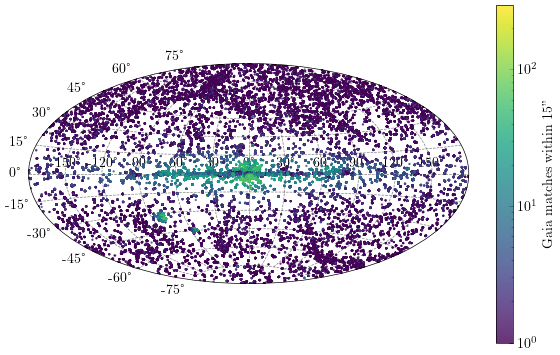

In [ ]:
# Scatter plot: all Chandra sources, colored by number of possible optical matches

# drop duplicates
unique_df = df_all_model.drop_duplicates(subset='csc21_name')

# get galactic coords
coords = SkyCoord(ra=unique_df['csc21_ra'], dec=unique_df['csc21_dec'], unit='degree')
gal = coords.galactic

# convert to radians, wrapping l at 180 deg so that it goes [-pi, +pi]
l = gal.l.wrap_at(180 * u.deg).radian
b = gal.b.radian

# "count" is the number of optical sources within 15"
count_vals = unique_df['count'].values

fig = plt.figure(figsize=(twocol, twocol/golden))
ax = plt.subplot(111, projection='aitoff')

# scatter: color = count
sc = ax.scatter(l, b, c=count_vals, s=0.4,
                cmap='viridis', norm=LogNorm(),
                alpha=0.8)

# colorbar
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Gaia matches within $15"$')

plt.savefig('figures/chandra_optical_sky.pdf', bbox_inches='tight')
plt.show()

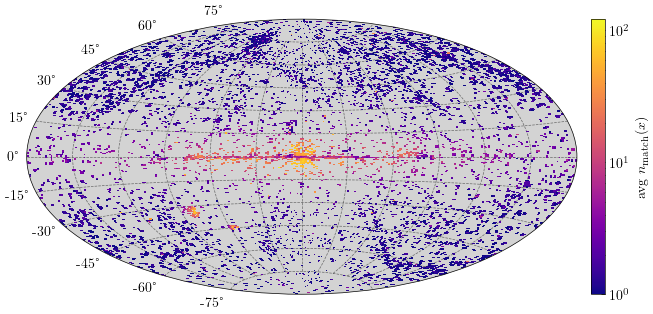

In [34]:
# Heatmap: average number of possible optical matches per X-ray source per bin

# drop duplicates
unique_df = df_all_model.drop_duplicates(subset='csc21_name')

# get galactic coords
coords = SkyCoord(ra=unique_df['csc21_ra'], dec=unique_df['csc21_dec'], unit='degree')
gal = coords.galactic

# convert to radians, wrapping l at 180 deg so that it goes [-pi, +pi]
l = gal.l.wrap_at(180 * u.deg).radian
b = gal.b.radian

# "count" is the number of optical sources within 15"
count_vals = unique_df['count'].values

# histogram in 2D, building the sum of 'count' per bin and the number of points per bin
bins = 300
H_sum, xedges, yedges = np.histogram2d(l, b, bins=bins, weights=count_vals)
H_num, _, _ = np.histogram2d(l, b, bins=[xedges, yedges])  # same edges

# average crowding, ignoring bins that have zero data
with np.errstate(invalid='ignore'):
    avg_crowding = H_sum / H_num  # array with shape (bins, bins)

# define bin centers for pcolormesh
xcenter = 0.5*(xedges[:-1] + xedges[1:])
ycenter = 0.5*(yedges[:-1] + yedges[1:])

# mask or set to NaN the bins with no coverage
avg_crowding[H_num < 1] = np.nan  # so those cells appear blank or a special color

fig = plt.figure(figsize=(twocol, twocol/golden))
ax = plt.subplot(111, projection='aitoff')
ax.set_facecolor('lightgray')  # so "no coverage" stands out if we set nan color to white

# pcolormesh with log color scale
pc = ax.pcolormesh(xcenter, ycenter, avg_crowding.T,  # note .T because histogram2d outputs [x,y]
                   cmap='plasma', norm=LogNorm(), shading='auto')

# delete labels from inside
ax.set_xticklabels([])
ax.set_axisbelow(True)

# colorbar whose height (or width) in sync with the master axes¶
pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
cbar = fig.colorbar(pc, cax=cax)
cbar.set_label("avg $n_{\\mathrm{match}}(x)$")

plt.savefig('figures/chandra_optical_sky_hist.pdf', bbox_inches='tight')
plt.show()


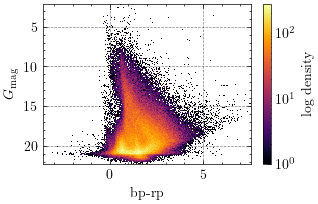

In [11]:
#bp-rp vs gmag for all sources with match_flag == 1
df_matches_nway = df_all_model[df_all_model['match_flag'] == 1]

# remove rows with NaN values in 'bp_rp' or 'phot_g_mean_mag'
df_matches_nway_clean = df_matches_nway.dropna(subset=['bp_rp', 'phot_g_mean_mag'])

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))

# 2D histogram with logarithmic color scale
hist = ax.hist2d(df_matches_nway_clean['bp_rp'], df_matches_nway_clean['phot_g_mean_mag'], bins=200, cmap='inferno', norm=LogNorm())

# color bar
cb = fig.colorbar(hist[3], ax=ax)
cb.set_label('log density')

ax.set_xlabel('bp-rp')
# latex 'G_{\text{mag}}'
ax.set_ylabel(r'$G_{\mathrm{mag}}$')
ax.invert_yaxis()  # invert y-axis to match the typical astronomical convention
plt.savefig('figures/bp_rp_vs_gmag_density_hist.pdf', bbox_inches='tight')
plt.show()

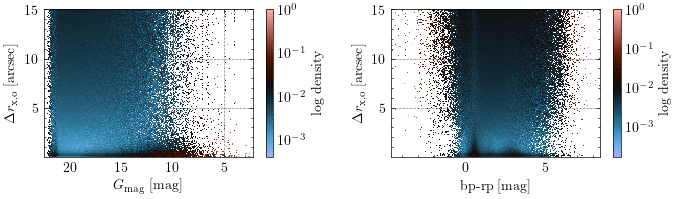

In [149]:
# 1x2 subplots comparing 'separation' vs phot_g_mean_mag and bp_rp, vertically normalized

fig, axes = plt.subplots(1, 2, figsize=set_size(twoc, fraction=1.0, subplots=(1, 2)))

# 1) separation vs phot_g_mean_mag
ax = axes[0]
df_g_clean = df_all_model.dropna(subset=['phot_g_mean_mag', 'separation'])
x_g = df_g_clean['phot_g_mean_mag'].values
y_sep = df_g_clean['separation'].values

H_g, xedges_g, yedges_g = np.histogram2d(x_g, y_sep, bins=200)
# normalize each row
H_g_sums = H_g.sum(axis=1)
H_g_sums[H_g_sums == 0] = 1  # avoid division by zero
H_g /= H_g_sums[:, np.newaxis]

im_g = axes[0].pcolormesh(xedges_g, yedges_g, H_g.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_g = fig.colorbar(im_g, ax=axes[0])
cb_g.set_label('log density')
ax.set_xlabel(r'$G_{\mathrm{mag}}$ [mag]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')
ax.invert_xaxis()  # invert x-axis to match astronomical convention

# 2) separation vs bp_rp
ax = axes[1]
df_bprp_clean = df_all_model.dropna(subset=['bp_rp', 'separation'])
x_bprp = df_bprp_clean['bp_rp'].values
y_sep = df_bprp_clean['separation'].values

H_bprp, xedges_bprp, yedges_bprp = np.histogram2d(x_bprp, y_sep, bins=200)
# normalize each row
H_bprp_sums = H_bprp.sum(axis=1)
H_bprp_sums[H_bprp_sums == 0] = 1  # avoid division by zero
H_bprp /= H_bprp_sums[:, np.newaxis]

mesh_bprp = ax.pcolormesh(xedges_bprp, yedges_bprp, H_bprp.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_bprp = fig.colorbar(mesh_bprp, ax=ax)
cb_bprp.set_label('log density')
ax.set_xlabel('bp-rp [mag]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')

plt.tight_layout()
plt.savefig('figures/separation_vs_params_density_hist_gaia.pdf', bbox_inches='tight')
plt.show()

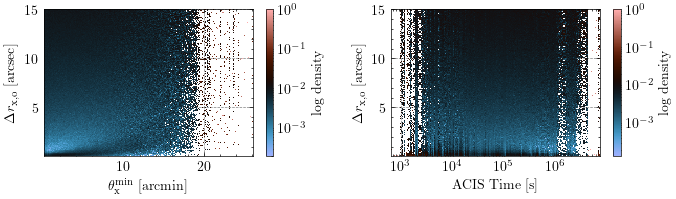

In [ ]:
# 1x2 subplots comparing 'separation' vs columns:
# min_theta_mean, acis_time

fig, axes = plt.subplots(1, 2, figsize=set_size(twoc, fraction=1.0, subplots=(1, 2)))

# 3) separation vs min_theta_mean
ax = axes[0]
df_theta_clean = df_all_model.dropna(subset=['min_theta_mean', 'separation'])

# Compute 2D histogram manually
counts_theta, xedges_theta, yedges_theta = np.histogram2d(
    df_theta_clean['min_theta_mean'],
    df_theta_clean['separation'],
    bins=200
)

# normalize each row
col_sums_theta = counts_theta.sum(axis=1)
col_sums_theta[col_sums_theta == 0] = 1  # avoid division by zero
counts_theta /= col_sums_theta[:, np.newaxis]


im_theta = axes[0].pcolormesh(xedges_theta, yedges_theta, counts_theta.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_theta = fig.colorbar(im_theta, ax=axes[0])
cb_theta.set_label('log density')
axes[0].set_xlabel(r'$\theta^{\mathrm{min}}_{\mathrm{x}}$ [arcmin]')
axes[0].set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')

# 4) separation vs acis_time
ax = axes[1]
df_acis_clean = df_all_model.dropna(subset=['acis_time', 'separation'])
xmin, xmax = df_acis_clean['acis_time'].min(), df_acis_clean['acis_time'].max()
# make logarithmically spaced bins for the x-axis
xbins = np.logspace(np.log10(xmin), np.log10(xmax), 200)
# Compute and normalize the second histogram
counts_acis, xedges_acis, yedges_acis = np.histogram2d(
    df_acis_clean['acis_time'],
    df_acis_clean['separation'],
    bins=[xbins, 200]
)

# normalize each row
col_sums_acis = counts_acis.sum(axis=1)
col_sums_acis[col_sums_acis == 0] = 1  # avoid division by zero
counts_acis /= col_sums_acis[:, np.newaxis]

im_acis = axes[1].pcolormesh(xedges_acis, yedges_acis, counts_acis.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_acis = fig.colorbar(im_acis, ax=axes[1])
cb_acis.set_label('log density')
axes[1].set_xlabel('ACIS Time [s]')
axes[1].set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('figures/separation_vs_params_density_hist_chandra.pdf', bbox_inches='tight')
plt.show()

#### The Positive and Negative set

In [ ]:
df_pos_gen, df_neg_gen = get_data_basic_matches(df_all_model, '0-3', 1.3)

Range 0-3: 30279 positives, 310020 negatives


In [ ]:
datasets = {
    "pos": df_pos_gen,
    "intermediate": df_neg_gen[df_neg_gen['negative_type'] == 'intermediate'],
    "clear_negative": df_neg_gen[df_neg_gen['negative_type'] == 'clear_negative'],
}

/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


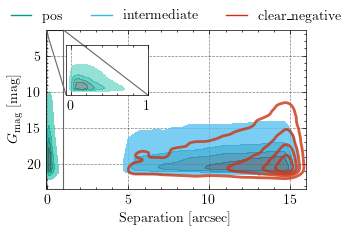

In [148]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# ------------------------------------------------------------------
# make the main figure
fig, ax = plt.subplots(figsize=(my_width, my_width / golden))

colors = ["#009988", "#33BBEE",  "#CC3311"]

for i, (name, data) in enumerate(datasets.items()):
    filtered = data.dropna(subset=['photflux_aper_b', 'separation'])

    x = filtered['separation'].values          # keep linear units!
    y = filtered['phot_g_mean_mag'].values

    # sample large sets for speed
    if len(x) > 200000:
        idx = np.random.choice(len(x), 200000, replace=False)
        x, y = x[idx], y[idx]

    # KDE for all three groups on the main axes
    sns.kdeplot(
        x=x, y=y,
        fill=(name != 'clear_negative'),
        levels=5,
        ax=ax,
        bw_adjust=0.8,
        linewidths=2,
        alpha=0.8,
        color=colors[i],
    )

    # manual legend handle
    ax.plot([], [], color=colors[i], label=name)

# ----- axis styling ------------------------------------------------
#ax.set_xscale('symlog', linthresh=2, base=10)     # linear core  (|x|<2")
ax.set_xlabel('Separation [arcsec]')
ax.set_ylabel(r'$G_{\mathrm{mag}}$ [mag]')
ax.invert_yaxis()

ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, 1.2), ncol=3,
          handlelength=1.5, frameon=False)

# ------------------------------------------------------------------
# inset that zooms on the 0‑2″ region for the 'pos' objects
# ------------------------------------------------------------------
axins = inset_axes(ax, width="35%", height="35%", loc='upper left',
                   bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),
                   bbox_transform=ax.transAxes)

# only the positive class; scatter is clearer here
pos = datasets['pos'].dropna(subset=['photflux_aper_b', 'separation'])
sns.kdeplot(
    x=pos['separation'], 
    y=pos['phot_g_mean_mag'], 
    ax=axins, 
    fill=True, 
    levels=5, 
    bw_adjust=0.8, 
    linewidths=2, 
    alpha=0.6, 
    color=colors[0]
)
axins.set_xlabel('')
axins.set_ylabel('')
axins.set_xlim(ax.get_xlim()[0], 1)
axins.set_ylim(ax.get_ylim())        # same magnitude range
axins.set_xticks([0, 1])  # ticks for inset
axins.set_yticks([])                 # keep it clean

# little grey frame around the zoomed region
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.4", lw=0.8)

# ------------------------------------------------------------------
plt.savefig('figures/kde_gmag_vs_separation_negative_types.pdf',
            bbox_inches='tight')
plt.show()


### Plots with train, val, test data

In [6]:
# whole csc
from astropy.io.votable import parse_single_table
from astropy.table import Table

# Load the VOTables
votable_path = '../data/csc211_epos.vot'
csc211_epos = votable_to_pandas(votable_path)

In [7]:
from src.data import get_data_basic_matches
from sklearn.model_selection import train_test_split
from src.utils import transform_features, normalize_train_test
import seaborn as sns 

In [8]:
from joblib import load

benchmark_ids = load('../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113/benchmark_ids.joblib')

def get_train_val_test_splits(df_all_model, benchmark_ids, range_offaxis='0-3', separation=1.3):
   # get initial positives and split test set
   df_pos, _ = get_data_basic_matches(df_all_model, range_offaxis, separation)
   cscids = df_pos['csc21_name'].unique()
   cscids_train_val, cscids_test = train_test_split(cscids, test_size=0.2, random_state=42)
   
   # get train/val split from filtered train_val data
   df_train_val = df_all_model[df_all_model['csc21_name'].isin(cscids_train_val)]
   train_pos, _ = get_data_basic_matches(df_train_val, range_offaxis, separation)
   train_val_cscids = train_pos['csc21_name'].unique()
   cscids_train, cscids_val = train_test_split(train_val_cscids, test_size=0.2, random_state=42)
   
   assert set(benchmark_ids) == set(cscids_test)
   
   # get final datasets
   splits = {}
   for name, ids in [('train', cscids_train), ('val', cscids_val), ('test', cscids_test)]:
       data = df_all_model[df_all_model['csc21_name'].isin(ids)]
       pos, neg = get_data_basic_matches(data, range_offaxis, separation)
       splits[name] = {'pos': pos, 'neg': neg, 'full': data}
       
   return splits

splits = get_train_val_test_splits(df_all_model, benchmark_ids)

def validate_splits(splits, model_path):
   """validate train/val splits match saved model data"""
   
   # combine pos/neg sets
   val_data = splits['val']['full']
   train_data = splits['train']['full']
   
   # load saved validation data
   X_eval_saved = load(os.path.join(model_path, 'X_eval.joblib'))
   y_eval_saved = load(os.path.join(model_path, 'y_eval.joblib'))
   
   # prepare validation data
   val_data = val_data.copy()
   val_data['eval_label'] = np.where(val_data['match_flag'] == 1, 1, 0)
   
   # preprocess
   X_train, _ = transform_features(train_data, log_transform=False, model_type='lgbm')
   X_val, cat_features = transform_features(val_data, log_transform=False, model_type='lgbm')
   _, X_val_norm, _ = normalize_train_test(X_train, X_val, method='none', 
                                         categorical_features=cat_features)
   
   # verify
   assert X_eval_saved.equals(X_val_norm)
   assert np.array_equal(y_eval_saved, val_data['eval_label'].values)
   
   return True

validate_splits(splits, '../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113')

Range 0-3: 30279 positives, 310020 negatives
Range 0-3: 24223 positives, 245627 negatives
Range 0-3: 19378 positives, 195135 negatives
Range 0-3: 4845 positives, 50492 negatives
Range 0-3: 6056 positives, 64393 negatives


True

In [9]:
# get the test data + everything from the dataset that was not in train and val
test_data = splits['test']['full']

# now get everything that was not in train and val
train_val_data = pd.concat([splits['train']['full'], splits['val']['full']])
train_val_ids = train_val_data['csc21_name'].unique()
not_train_val_data = df_all_model[~df_all_model['csc21_name'].isin(train_val_ids)].copy()

# check if test is IN not_train_val_data
assert set(test_data['csc21_name'].unique()) <= set(not_train_val_data['csc21_name'].unique())

In [10]:
'''
this saves the ids of the train, val, and test sets to text files
run only once
'''

train_ids = splits['train']['full']['csc21_name'].unique()
val_ids = splits['val']['full']['csc21_name'].unique()
test_ids = splits['test']['full']['csc21_name'].unique()

# save each as txt
train_ids_path = os.path.join('output', 'train_ids_full_neg_study_dis_niter200.txt')
val_ids_path = os.path.join('output', 'val_ids_full_neg_study_dis_niter200.txt')
test_ids_path = os.path.join('output', 'test_ids_full_neg_study_dis_niter200.txt')
#np.savetxt(train_ids_path, train_ids, fmt='%s')
#np.savetxt(val_ids_path, val_ids, fmt='%s')
#np.savetxt(test_ids_path, test_ids, fmt='%s')

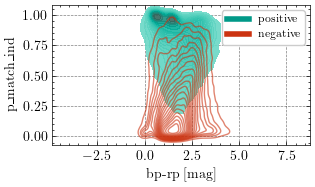

In [11]:
# do this plots for several features
# the 1-d distribution of all the features of all the ML matches


# Plot distributions of bp-rp vs p_match_ind for training and test datasets

fig, axes = plt.subplots(1, 1, figsize=(my_width, my_width/golden))
train_val_neg = train_val_data[train_val_data['match_flag'] != 1]
train_val_pos = train_val_data[train_val_data['match_flag'] == 1]
# Training data
sns.kdeplot(
    x=train_val_pos['bp_rp'], 
    y=train_val_pos['p_match_ind'], 
    fill=True, 
    levels=20, 
    color='#009988', 
    ax=axes,
    bw_adjust=0.8,
    alpha=0.9,
    label='positive'
    )

# Test data
sns.kdeplot(
    x=train_val_neg['bp_rp'], 
    y=train_val_neg['p_match_ind'], 
    fill=False, 
    levels=20, 
    color='#CC3311',
    ax=axes,
    bw_adjust=0.8,
    alpha=0.6,
    label='negative'
    )

axes.set_xlabel('bp-rp [mag]')
axes.set_ylabel('p_match_ind')
plt.tight_layout()
# add legend
handles, labels = axes.get_legend_handles_labels()
# create custom legend
legend = [plt.Line2D([0], [0], color='#009988', lw=4, label='positive'),
          plt.Line2D([0], [0], color='#CC3311', lw=4, label='negative')]
axes.legend(handles=legend, loc='upper right', fontsize=8)
# add title
plt.savefig('figures/bp_rp_vs_p_match_ind_train_val_test.pdf', bbox_inches='tight')

#### Validation empirical CDF

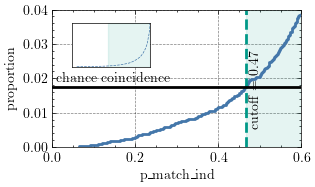

In [11]:
filtered_df = train_val_data[
    (train_val_data['p_i'] == 1) &
    (train_val_data['p_any'] > 0.99) &
    (train_val_data['count'] == 1)
]

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))

# ecdf curve
sns.ecdfplot(filtered_df['p_match_ind'], linewidth=2, ax=ax, label='train/val')

# shade region above cutoff
chance_coincidence = 0.0176
# find cutoff p_match_ind for that y
x_cut = np.interp(
    chance_coincidence,
    np.linspace(0, 1, len(filtered_df)),
    np.sort(filtered_df['p_match_ind'])
)
ax.axvspan(x_cut, 0.6, alpha=0.1, color='#009988')

# vertical line at cutoff
ax.axvline(x_cut, linestyle='--', linewidth=2, color='#009988')
ax.text(x_cut + 0.005, 0.005,
        f'cutoff = {x_cut:.2f}',
        rotation=90, va='bottom', ha='left')

# bold chance line
ax.axhline(chance_coincidence, color='black', linestyle='-', linewidth=2, label='chance coincidence')
ax.text(0.01, chance_coincidence + 0.002,
        'chance coincidence',
        va='center', ha='left', fontsize=10)

# single-side axis labels in percent
ax.set_xlabel('p_match_ind')
ax.set_ylabel('proportion')
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 0.04)
plt.tight_layout()


# put a small version of the full plot in the corner
# inset axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="35%", height="35%", loc='upper left',
                   bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),
                     bbox_transform=ax.transAxes)
# plot the full dataset
sns.ecdfplot(filtered_df['p_match_ind'], linewidth=0.5, ax=axins, linestyle='--', label='full dataset')
# shade region above cutoff
axins.axvspan(x_cut, 1, alpha=0.1, color='#009988')

# remove labels from inset
axins.set_xlabel('')
axins.set_ylabel('')
axins.set_xticks([])
axins.set_yticks([])
axins.set_xlim(0, 1)
plt.savefig('figures/p_match_ind_ecdf.pdf', bbox_inches='tight')
plt.show()

#### ROC

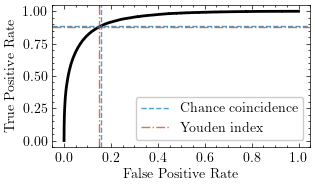

In [12]:
from cProfile import label
from textwrap import fill
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC-AUC
y_true = (train_val_data['match_flag'] == 1).astype(int)  # True labels
y_scores = train_val_data['p_match_ind']  # Predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Find Youden index (maximizing TPR - FPR)
youden_index = np.argmax(tpr - fpr)
youden_threshold = thresholds[youden_index]

# Plot ROC-AUC curve
fig, ax = plt.subplots(figsize=(my_width, my_width / golden))
# deactivate grid 
ax.grid(False)


ax.plot(fpr, tpr, color='black', linewidth=2)
#ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Mark chance-coincidence threshold
cc_threshold = 0.466
chance_index = np.argmin(np.abs(thresholds - cc_threshold))
#ax.scatter(fpr[chance_index], tpr[chance_index], color='#EE7733', label='Chance coincidence', zorder=5, marker='o')
ax.axvline(fpr[chance_index], linestyle='--', color='#0077BB', alpha=0.7, label='Chance coincidence')
ax.axhline(tpr[chance_index], linestyle='--', color='#0077BB', alpha=0.7)

# Mark Youden index threshold

# Mark Youden index threshold
#ax.scatter(fpr[youden_index], tpr[youden_index], color='#33BBEE', label='Youden index', zorder=5, marker='s')
ax.axvline(fpr[youden_index], linestyle='dashdot', color='#CC3311', alpha=0.7, label='Youden index')
ax.axhline(tpr[youden_index], linestyle='dashdot', color='#CC3311', alpha=0.7)
# Add labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/roc_auc_with_thresholds.pdf', bbox_inches='tight')
plt.show()


In [13]:
cc_threshold

0.466

In [14]:
# take chance coincidence threshold
# evaluate the model on the test set directly

# get the test data
test_data = splits['test']['full']
test_pos = splits['test']['pos']
test_neg = splits['test']['neg']

# generate various statistics
# including accuracy, precision, recall, f1-score
# and agreement
# and more fancy ones like Matthews correlation coefficient

def generate_statistics(df, threshold=0.466):
    """generate statistics for the given dataframe"""
    # get the true labels
    y_true = (df['match_flag'] == 1).astype(int)
    
    # get the predicted labels
    y_pred = (df['p_match_ind'] >= threshold).astype(int)
    
    # get the confusion matrix
    cm = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'])
    
    # calculate accuracy
    accuracy = (cm.values[0, 0] + cm.values[1, 1]) / cm.values.sum()

    # calcualate accuracy for the positive class
    accuracy_pos = cm.values[1, 1] / (cm.values[1, 1] + cm.values[1, 0])
    # calculate accuracy for the negative class
    accuracy_neg = cm.values[0, 0] / (cm.values[0, 0] + cm.values[0, 1])
    
    # calculate precision
    precision = cm.values[1, 1] / (cm.values[1, 1] + cm.values[0, 1])
    # calculate precision for the negative class
    precision_neg = cm.values[0, 0] / (cm.values[0, 0] + cm.values[1, 0])
    
    # calculate recall
    recall = cm.values[1, 1] / (cm.values[1, 1] + cm.values[1, 0])
    
    # calculate f1-score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return {
        'accuracy': accuracy,
        'accuracy_pos': accuracy_pos,
        'accuracy_neg': accuracy_neg,
        'precision': precision,
        'precision_neg': precision_neg,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': cm
    }

# generate statistics for the test set
test_stats = generate_statistics(test_data, threshold=0.466)


In [15]:
test_stats

{'accuracy': 0.837324984074059,
 'accuracy_pos': 0.7909511228533685,
 'accuracy_neg': 0.841471878091638,
 'precision': 0.3085147494525312,
 'precision_neg': 0.9782672137057319,
 'recall': 0.7909511228533685,
 'f1_score': 0.4438884255398016,
 'confusion_matrix': Predicted      0      1
 True                   
 0          56987  10736
 1           1266   4790}

In [16]:
from src.classification import get_match_label_advanced


def generate_stats_thresholds(df, threshold=0.466):
    """generate statistics for the given dataframe"""
    # get the true labels
    y_true = (df['match_flag'] == 1).astype(int)

    y_pred = get_match_label_advanced(df, p_threshold=threshold)

    y_pred =(y_pred['label'] == 1).astype(int)
    
    # get the confusion matrix
    cm = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'])
    
    # calculate accuracy
    accuracy = (cm.values[0, 0] + cm.values[1, 1]) / cm.values.sum()

    # calcualate accuracy for the positive class
    accuracy_pos = cm.values[1, 1] / (cm.values[1, 1] + cm.values[1, 0])
    # calculate accuracy for the negative class
    accuracy_neg = cm.values[0, 0] / (cm.values[0, 0] + cm.values[0, 1])
    
    # calculate precision
    precision = cm.values[1, 1] / (cm.values[1, 1] + cm.values[0, 1])
    # calculate precision for the negative class
    precision_neg = cm.values[0, 0] / (cm.values[0, 0] + cm.values[1, 0])
    
    # calculate recall
    recall = cm.values[1, 1] / (cm.values[1, 1] + cm.values[1, 0])
    
    # calculate f1-score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return {
        'accuracy': accuracy,
        'accuracy_pos': accuracy_pos,
        'accuracy_neg': accuracy_neg,
        'precision': precision,
        'precision_neg': precision_neg,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': cm
    }

# generate statistics for the test set
test_stats = generate_stats_thresholds(test_data, threshold=0.466)


In [17]:
test_stats

{'accuracy': 0.9802653871697908,
 'accuracy_pos': 0.7909511228533685,
 'accuracy_neg': 0.9971944538782984,
 'precision': 0.9618473895582329,
 'precision_neg': 0.9815985697466533,
 'recall': 0.7909511228533685,
 'f1_score': 0.8680681406306633,
 'confusion_matrix': Predicted      0     1
 True                  
 0          67533   190
 1           1266  4790}

In [22]:
4790+1266

6056

In [23]:
def create_performance_metrics(df, p_threshold=0.466):
   """compute match statistics between nway and ml model"""
   metrics = {}
   
   # base counts
   metrics['N_CSC'] = df['csc21_name'].nunique()
   metrics['N_yNWAY'] = df[df['p_any'] > 0.5]['csc21_name'].nunique()
   
   # combined criteria using label column
   ok_matches = (df['p_any'] > 0.5) & (df['label'] == 1) & (df['match_flag'] == 1)
   metrics['N_OK'] = df[ok_matches]['csc21_name'].nunique()
   
   no_ml = (df['p_any'] > 0.5) & ~df.groupby('csc21_name')['label'].transform(any)
   metrics['N_NoML'] = df[no_ml]['csc21_name'].nunique()
   
   flip = (df['p_any'] <= 0.5) & (df['label'] == 1)
   metrics['N_FLIP'] = df[flip]['csc21_name'].nunique()
   
   none = (df['p_any'] <= 0.5) & ~df.groupby('csc21_name')['label'].transform(any)
   metrics['N_NONE'] = df[none]['csc21_name'].nunique()
   
   # single/multiple match counts 
   ok_single = ok_matches & (df.groupby('csc21_name')['label'].transform(sum) == 1)
   metrics['N_yNWAY+yMLeq1'] = df[ok_single]['csc21_name'].nunique()
   metrics['N_yNWAY+yMLgt1'] = metrics['N_OK'] - metrics['N_yNWAY+yMLeq1']
   
   flip_single = flip & (df.groupby('csc21_name')['label'].transform(sum) == 1)
   metrics['N_FLIPeq1'] = df[flip_single]['csc21_name'].nunique()
   metrics['N_FLIPgt1'] = metrics['N_FLIP'] - metrics['N_FLIPeq1']

   # For each Gaia candidate (gaia_id) that has at least one row with high p_match_ind,
   # count it only if in all rows the candidate is outside the separation threshold.   
   high_ml = df[df['p_match_ind'] > p_threshold]
   gaia_flag = high_ml.groupby('gaia3_source_id').apply(lambda g: (g['separation'] > g['threshold_sep']).all())
   print(high_ml['threshold_sep']) 
   print(gaia_flag.sum())
   metrics['N_MLglobal'] = gaia_flag[gaia_flag].index.nunique()

   table = f"""
   N_CSC = {metrics['N_CSC']}
   N_yNWAY = {metrics['N_yNWAY']}
   N_OK = {metrics['N_OK']}
   N_NoML = {metrics['N_NoML']}
   N_FLIP = {metrics['N_FLIP']}
   N_NONE = {metrics['N_NONE']}
   N_yNWAY+yMLeq1 = {metrics['N_yNWAY+yMLeq1']}
   N_yNWAY+yMLgt1 = {metrics['N_yNWAY+yMLgt1']}
   N_FLIPeq1 = {metrics['N_FLIPeq1']}
   N_FLIPgt1 = {metrics['N_FLIPgt1']}
   N_MLglobal = {metrics['N_MLglobal']}
   """

   return metrics, table

In [24]:
test_labeled = get_match_label_advanced(test_data, p_threshold=0.466)
create_performance_metrics(test_labeled, p_threshold=0.466)

/var/folders/2j/bgzn208n7s93xhqxhxjy85nh0000gp/T/ipykernel_28623/915769620.py:23: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ok_single = ok_matches & (df.groupby('csc21_name')['label'].transform(sum) == 1)
/var/folders/2j/bgzn208n7s93xhqxhxjy85nh0000gp/T/ipykernel_28623/915769620.py:27: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flip_single = flip & (df.groupby('csc21_name')['label'].transform(sum) == 1)


113        2
157        2
235        2
243        2
281        2
          ..
2383233    2
2383239    2
2383243    2
2398594    2
2398597    2
Name: threshold_sep, Length: 15526, dtype: int64
8867


/var/folders/2j/bgzn208n7s93xhqxhxjy85nh0000gp/T/ipykernel_28623/915769620.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaia_flag = high_ml.groupby('gaia3_source_id').apply(lambda g: (g['separation'] > g['threshold_sep']).all())


({'N_CSC': 6056,
  'N_yNWAY': 6056,
  'N_OK': 4790,
  'N_NoML': 1162,
  'N_FLIP': 0,
  'N_NONE': 0,
  'N_yNWAY+yMLeq1': 4710,
  'N_yNWAY+yMLgt1': 80,
  'N_FLIPeq1': 0,
  'N_FLIPgt1': 0,
  'N_MLglobal': 8867},
 '\n   N_CSC = 6056\n   N_yNWAY = 6056\n   N_OK = 4790\n   N_NoML = 1162\n   N_FLIP = 0\n   N_NONE = 0\n   N_yNWAY+yMLeq1 = 4710\n   N_yNWAY+yMLgt1 = 80\n   N_FLIPeq1 = 0\n   N_FLIPgt1 = 0\n   N_MLglobal = 8867\n   ')

In [25]:
# compute jaccard index
def compute_jaccard_index(df):
    """compute jaccard index between nway and ml model"""
    # get the true labels
    y_true = (df['match_flag'] == 1).astype(int)
    
    # get the predicted labels
    y_pred = (df['label'] == 1).astype(int)
    
    # get the confusion matrix
    cm = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'])
    
    # calculate jaccard index
    jaccard_index = cm.values[1, 1] / (cm.values[1, 1] + cm.values[0, 1] + cm.values[1, 0])
    
    return jaccard_index
# generate statistics for the test set
jaccard_index = compute_jaccard_index(test_labeled)

In [30]:
round(jaccard_index, 2)

0.77

In [31]:
test_labeled.shape

(73779, 78)

#### full catalog plots


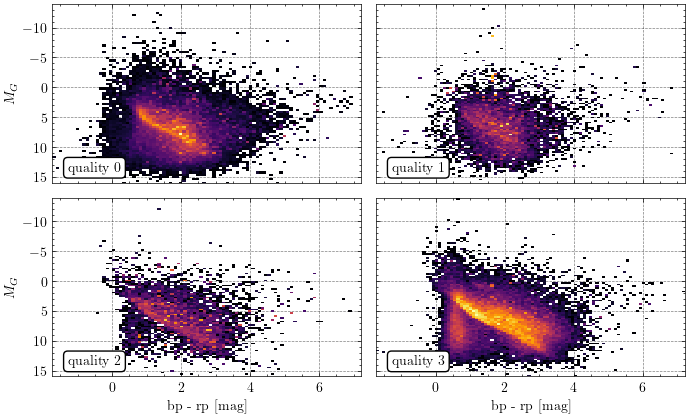

In [14]:
from matplotlib import colors
from numpy import invert
# load ..catalogs/csc_gaia_primary_counterparts.csv
best_matches = pd.read_csv('../catalogs/csc_gaia_primary_counterparts.csv')
# take out the train/val ids
best_matches = best_matches[~best_matches['csc21_name'].isin(train_val_ids)]
best_matches['gaia3_source_id'] = best_matches['gaia3_source_id'].astype(str)
df_all_model['gaia3_source_id'] = df_all_model['gaia3_source_id'].astype(str)

best_matches_full = pd.merge(
    best_matches,
    df_all_model[['gaia3_source_id', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_over_error', 'hard_hs']],
    on='gaia3_source_id',
    how='left'
)

fig, axes = plt.subplots(2, 2, figsize=set_size(twoc, fraction=1.0, subplots=(2, 2)), sharey=True, sharex=True)

g = best_matches_full.copy()
g = g.dropna(subset=['bp_rp', 'phot_g_mean_mag', 'parallax', 'quality_label'])
g = g.query('parallax > 0')
g['abs_mag'] = g['phot_g_mean_mag'] - 5 * np.log10(1000 / g['parallax']) + 5

labels = ['quality 0', 'quality 1', 'quality 2', 'quality 3']
for i, q in enumerate([0, 1, 2, 3]):
    gq = g[g['quality_label'] == q]
    row, col = divmod(i, 2)
    ax = axes[row, col]
    # Use 2D histogram instead of hexbin
    h = axes[row, col].hist2d(
        gq['bp_rp'], gq['abs_mag'],
        bins=100, cmap='inferno', norm=colors.PowerNorm(0.5), cmin=1
    )
    if col == 0:
        axes[row, col].set_ylabel(r'$M_G$')
    if row == 1:
        axes[row, col].set_xlabel('bp - rp [mag]')

    ax.annotate(f'quality {q}',
        xy=(0.05,0.05), xycoords='axes fraction',
        ha='left', va='bottom', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3",
                    edgecolor='black', facecolor='white'))
axes[0, 0].invert_yaxis()  # invert y-axis to match the typical astronomical convention

plt.tight_layout()
plt.savefig('figures/hr_diagram_best_matches_q.pdf', bbox_inches='tight')

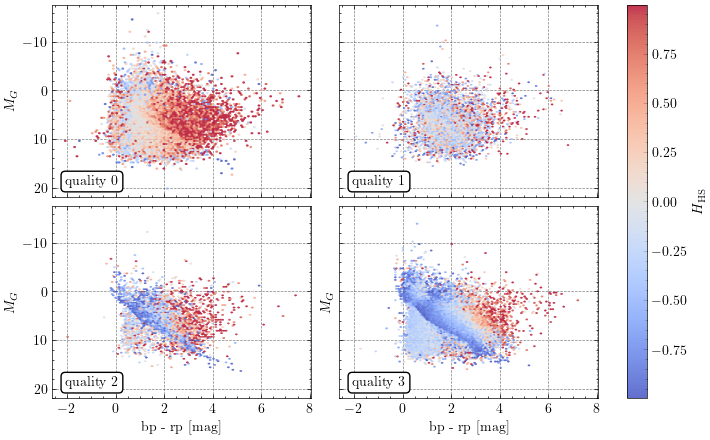

In [547]:
from matplotlib import colors

fig, axes = plt.subplots(2, 2, figsize=set_size(twoc, fraction=1.0, subplots=(2, 2)), sharey=True, sharex=True, layout='compressed')

g = best_matches_full.copy()
g = g.dropna(subset=['bp_rp', 'phot_g_mean_mag', 'parallax', 'quality_label'])
g = g.query('parallax > 0')
g['abs_mag'] = g['phot_g_mean_mag'] - 5 * np.log10(1000 / g['parallax']) + 5

labels = ['quality 0', 'quality 1', 'quality 2', 'quality 3']
for i, q in enumerate([0, 1, 2, 3]):
    ax = axes.flatten()[i]
    gq = g[g['quality_label'] == q]
    row, col = divmod(i, 2)
    hb = axes[row, col].hexbin(
    gq['bp_rp'], gq['abs_mag'],
    C=gq['hard_hs'],
    reduce_C_function=np.nanmedian,
    gridsize=100, cmap='coolwarm',
    alpha=0.8, linewidths=0.2
    )
    if col == 0:
        axes[row, col].set_ylabel(r'$M_G$')
    if row == 1:
        axes[row, col].set_xlabel('bp - rp [mag]')
    ax.annotate(f'quality {q}',
            xy=(0.05,0.05), xycoords='axes fraction',
            ha='left', va='bottom', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3",
                        edgecolor='black', facecolor='white'))

axes[0, 0].invert_yaxis()  # invert y-axis to match the typical astronomical convention
# cbar
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label(r'$H_{\mathrm{HS}}$')
ax.set_ylabel(r'$M_G$')
plt.savefig('figures/hr_diagram_test_pos_hardness.pdf')
plt.show()


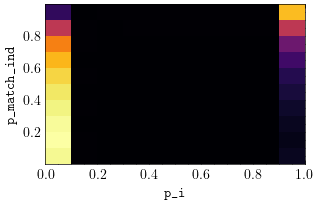

In [351]:
# plot p_i vs p_match_ind
fig, ax = plt.subplots(figsize=(my_width, my_width/golden))
# plot p_i vs p_match_ind
# hist2d
# 2D histogram of p_i vs p_match_ind, normalized by row (p_i bins)
# dropna to avoid NaNs
data = df_all_model[['p_i', 'p_match_ind']].dropna()
# define bins
bins = 10
x = data['p_i'].values
y = data['p_match_ind'].values
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
# normalize by p_match_ind
col_sum = H.sum(axis=0)

# avoid division by zero
col_sum[col_sum == 0] = 1

# normalize each row
H_norm = H / col_sum

# plot with pcolormesh
pcm = ax.pcolormesh(xedges, yedges, H_norm.T, cmap='inferno', shading='auto')
# add colorbar
#cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('density')
ax.set_xlabel(r'$\texttt{p\_i}$')
ax.set_ylabel(r'$\texttt{p\_match\_ind}$')

plt.savefig('figures/p_i_vs_p_match_ind.pdf', bbox_inches='tight')

/var/folders/2j/bgzn208n7s93xhqxhxjy85nh0000gp/T/ipykernel_86445/1678628738.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


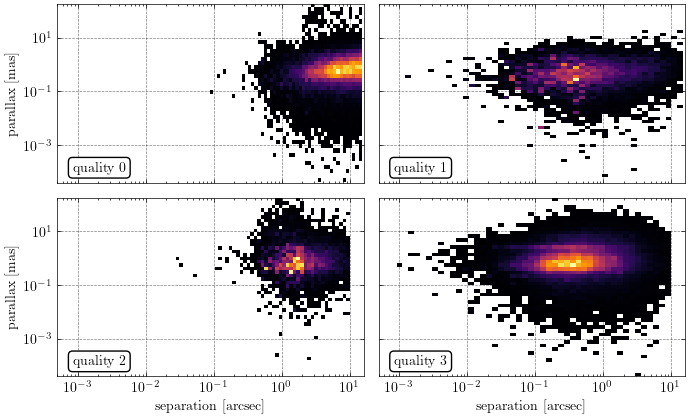

In [15]:
fig, axes = plt.subplots(2, 2, figsize=set_size(twoc, fraction=1.0, subplots=(2, 2)), sharex=True, sharey=True, layout='compressed')

labels = ['quality 0', 'quality 1', 'quality 2', 'quality 3']
g = best_matches_full.copy()
g = g.dropna(subset=['parallax', 'separation', 'quality_label'])
g = g.query('parallax > 0')
for i, q in enumerate([0, 1, 2, 3]):
    ax = axes.flatten()[i]
    gq = g[g['quality_label'] == q]
    row, col = divmod(i, 2)
    nbins=50
    ybins = np.logspace(
        np.log10(np.nanmin(gq['parallax'])), np.log10(np.nanmax(gq['parallax'])), nbins
    )

    xbins = np.logspace(
        np.log10(gq['separation'].min()), np.log10(gq['separation'].max()), nbins
    )
    counts, _, _ = np.histogram2d(gq['separation'], gq['parallax'], bins=(xbins, ybins))
    
    # cmin=1 
    counts[counts == 0] = np.nan
    axes[row, col].pcolormesh(
        xbins, ybins, counts.T,
        cmap='inferno', shading='auto',
    )

    axes[row, col].set_yscale('log')
    axes[row, col].set_xscale('log')

    axes[row, col].set_ylim(ymin=ybins[0], ymax=ybins[-1])
    axes[row, col].set_xlim(xmin=xbins[0], xmax=16)
    if col == 0:
        axes[row, col].set_ylabel('parallax [mas]')
    if row == 1:
        axes[row, col].set_xlabel('separation [arcsec]')
    ax.annotate(f'quality {q}',
                xy=(0.05,0.05), xycoords='axes fraction',
                ha='left', va='bottom', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.savefig('figures/separation_vs_parallax.pdf', bbox_inches='tight')
plt.show()

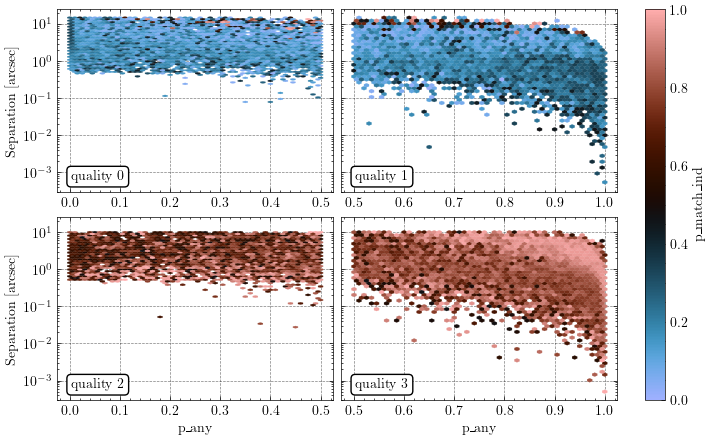

In [474]:

# prepare fig/axes
fig, axes = plt.subplots(2, 2,
                         figsize=set_size(twoc, fraction=1.0, subplots=(2, 2)),
                         sharey=True, layout='compressed')

# define a common norm + cmap so all panels share the same scale
cmap = cm.berlin
vmin = 0
vmax = 1
norm = plt.Normalize(vmin=vmin, vmax=vmax)

for i, q in enumerate([0,1,2,3]):
    ax = axes.flatten()[i]
    gq = best_matches_full[best_matches_full['quality_label']==q]
    hb = ax.hexbin(
        gq['p_any'],
        gq['separation'],
        C=gq['p_match_ind'],
        reduce_C_function=np.nanmedian,
        gridsize=50,
        cmap=cmap,
        norm=norm,
        linewidths=0.2,
        yscale='log',
    )

    # only label outer axes
    if i in (0,2):
        ax.set_ylabel('Separation [arcsec]')
    if i in (2,3):
        ax.set_xlabel('p_any')

    ax.annotate(f'quality {q}',
                xy=(0.05,0.05), xycoords='axes fraction',
                ha='left', va='bottom', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='black', facecolor='white'))
# one shared colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes.ravel().tolist(),
    label='p_match_ind',
    orientation='vertical',
)

plt.savefig('figures/separation_vs_p_any.pdf', bbox_inches='tight')

In [459]:
g.p_match_ind.min()

0.0021215514770803

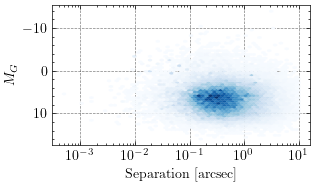

In [ ]:
# Compute absolute magnitude M_G for best quality matches
g_best = best_matches_full.copy()
g_best = g_best.dropna(subset=['bp_rp', 'phot_g_mean_mag', 'parallax', 'quality_label', 'separation'])
g_best = g_best.query('parallax > 0 and quality_label == 3')
g_best['abs_mag'] = g_best['phot_g_mean_mag'] - 5 * np.log10(1000 / g_best['parallax']) + 5

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))
hb = ax.hexbin(
    g_best['separation'],
    g_best['abs_mag'],
    gridsize=60,
    cmap='Blues',
    mincnt=1,
    xscale='log',
    linewidths=0.2,
)
ax.invert_yaxis()
ax.set_xlabel('Separation [arcsec]')
ax.set_ylabel(r'$M_G$')
plt.tight_layout()
plt.savefig('figures/hexbin_MG_vs_separation_best_quality.pdf', bbox_inches='tight')
plt.show()

/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


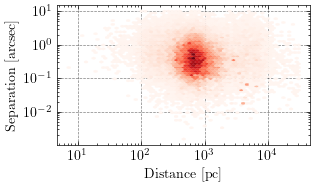

In [34]:
best_matches_full = pd.merge(
    best_matches,
    df_all_model[['gaia3_source_id', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_over_error', 'hard_hs', 'distance_gspphot']],
    on='gaia3_source_id',
    how='left'
)

# Compute absolute magnitude M_G for best quality matches
g_best = best_matches_full.copy()
#g_best = g_best.dropna(subset=['bp_rp', 'phot_g_mean_mag', 'parallax', 'quality_label', 'separation'])
g_best = g_best.query('quality_label == 3')
g_best['abs_mag'] = g_best['phot_g_mean_mag'] - 5 * np.log10(1000 / g_best['parallax']) + 5

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))
hb = ax.hexbin(
    g_best['distance_gspphot'],
    g_best['separation'],
    gridsize=60,
    cmap='Reds',
    mincnt=1,
    yscale='log',
    xscale='log',
    linewidths=0.2,
)
ax.set_xlabel('Distance [pc]')
ax.set_ylabel('Separation [arcsec]')
plt.tight_layout()
plt.savefig('figures/hexbin_distance_vs_separation_best_quality.pdf', bbox_inches='tight')
plt.show()


In [35]:
# compute percentage below 10^3 parsecs
distance_threshold = 1000  # in parsecs
# where distance is not nan
g_best = g_best[g_best['distance_gspphot'].notna()]
percentage_below_threshold = (g_best['distance_gspphot'] < distance_threshold).sum()*100 / len(g_best)
print(f"Percentage of best quality matches with distance < {distance_threshold} pc: {percentage_below_threshold:.2f}%")

# and median
median_distance = g_best['distance_gspphot'].median()
print(f"Median distance of best quality matches: {median_distance:.2f} pc")

Percentage of best quality matches with distance < 1000 pc: 67.53%
Median distance of best quality matches: 732.53 pc


In [40]:
# numbers

best_matches_df = pd.read_csv('../catalogs/csc_gaia_primary_counterparts.csv')

In [42]:
# number of sources for each quality label
quality_counts = best_matches_df['quality_label'].value_counts().sort_index()
print("Number of sources for each quality label:")
print(quality_counts)

Number of sources for each quality label:
quality_label
0    121204
1     19464
2     10913
3    102728
Name: count, dtype: int64


In [44]:
best_matches_df['csc21_name'].nunique()

254309